In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import make_scorer,roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

### Import Data

In [4]:
processed_base_dir = "../data/processed/"
raw_base_dir = "../data/raw/"

In [5]:
train_raw_filepath = raw_base_dir + "RAID0-train-8.csv"
test_raw_filepath = raw_base_dir + "RAID0-test-8.csv"
train_decimal_filepath = processed_base_dir + "RAID0-train-8-decimal.csv"
test_decimal_filepath = processed_base_dir + "RAID0-test-8-decimal.csv"

In [6]:
train_raw_df = pd.read_csv(train_raw_filepath, header = None)
test_raw_df = pd.read_csv(test_raw_filepath, header = None)
train_decimal_df = pd.read_csv(train_decimal_filepath)
test_decimal_df = pd.read_csv(test_decimal_filepath) 

In [7]:
train_raw_df[160].loc[train_raw_df[160]==0].count()

92052

In [8]:
train_decimal_df["ebusy"].loc[train_decimal_df["ebusy"]==0].count()

92052

In [9]:
def get_X_y(df, mode = "raw"):
    #'''
    #df : dataframe
    #returns X,y
    #'''
    
    X = []
    y = []
    if mode == "decimal":
        X = df.iloc[:,:5].values
        y = df.iloc[:,5].values
    else:
        X = df.iloc[:,:160].values
        y = df.iloc[:,160].values
    return X,y

In [10]:
X_raw, y_raw = get_X_y(train_raw_df)
X_test_raw, y_test_raw = get_X_y(test_raw_df)
X_decimal, y_decimal = get_X_y(train_decimal_df, "decimal")
X_test_decimal, y_test_decimal = get_X_y(test_decimal_df, "decimal")

In [11]:
np.count_nonzero(y_decimal)

7948

In [12]:
np.count_nonzero(y_raw)

7948

## Cross validation and Upsampling

In [13]:
figure_base_dir = "../reports/figures/"

In [14]:
def plot_auc_curve(y_true, prediction, datatype="raw"):
    fpr, tpr, threshold = roc_curve(y_true, prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(figure_base_dir+datatype+"_LogisticRegression_roc_curve.png")
    plt.show()

In [15]:
def plot_confusion_matrix(cm, classes,
                          datatype="raw",
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(figure_base_dir+datatype+"_LogisticRegression_confusion_matrix.png")
    plt.show()

In [16]:
def accuracy_summary(y_true, y_pred):
    print("Accuracy : {}".format(accuracy_score(y_pred=y_pred, y_true=y_true)))
    print("Precision : {}".format(precision_score(y_pred=y_pred, y_true=y_true)))
    print("Recall : {}".format(recall_score(y_pred=y_pred, y_true=y_true)))

Cross validation with 33% validation data ratio

### Raw Binary Representation

In [17]:
X_raw_train, X_raw_val, y_raw_train, y_raw_val = train_test_split(X_raw, y_raw, test_size=0.33, random_state=1)

In [18]:
upsampler = SMOTE(random_state=1)
X_raw_train_upsampled, y_raw_train_upsampled = upsampler.fit_resample(X_raw_train , y_raw_train)

In [19]:
len(X_raw_train_upsampled)

123146

#### Grid search parameter

In [20]:
param_grid ={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
clf = GridSearchCV(LogisticRegression(random_state=1), scoring=scoring, param_grid=param_grid, refit="AUC")

clf.fit(X_raw_train_upsampled, y_raw_train_upsampled)

/home/adylan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433:

/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=0)

In [21]:
print(clf.best_estimator_)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [22]:
prediction = clf.best_estimator_.predict(X_raw_val)

#### Confusion Matrix

Confusion matrix, without normalization
[[27234  3245]
 [ 2262   259]]


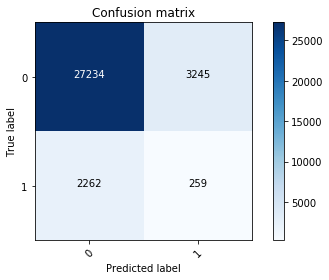

In [23]:
cnf_matrix = confusion_matrix(y_raw_val, prediction)
plot_confusion_matrix(cnf_matrix, classes=[0,1])

#### ROC Curve

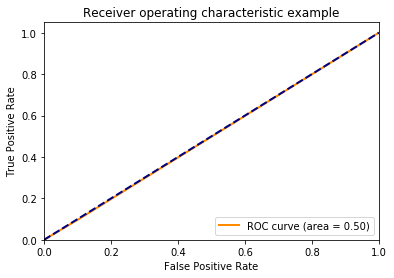

In [24]:
plot_auc_curve(y_raw_val, prediction)

In [25]:
accuracy_summary(y_raw_val, prediction)

Accuracy : 0.8331212121212122
Precision : 0.07391552511415525
Recall : 0.10273700912336374


### Decimal Representation

In [26]:
X_decimal_train, X_decimal_val, y_decimal_train, y_decimal_val = train_test_split(X_decimal, y_decimal, test_size=0.33, random_state=1)

In [27]:
upsampler = SMOTE(random_state=2)
X_decimal_train_upsampled, y_decimal_train_upsampled = upsampler.fit_resample(X_decimal_train , y_decimal_train)

In [28]:
len(X_decimal_train_upsampled)

123146

#### Grid search hyper parameter

In [29]:
param_grid ={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
decimal_clf = GridSearchCV(LogisticRegression(random_state=1), scoring=scoring, param_grid=param_grid, refit="AUC")

decimal_clf.fit(X_decimal_train_upsampled, y_decimal_train_upsampled)

/home/adylan/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433:

/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adylan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='AUC', return_train_score='warn',
       scoring={'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)},
       verbose=0)

In [30]:
decimal_prediction = decimal_clf.best_estimator_.predict(X_decimal_val)

#### Confusion Matrix

Confusion matrix, without normalization
[[15457 15022]
 [ 1289  1232]]


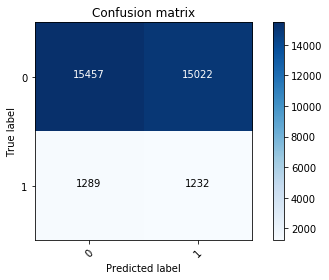

In [31]:
cnf_matrix = confusion_matrix(y_decimal_val, decimal_prediction)
plot_confusion_matrix(cnf_matrix, classes=[0,1],datatype="decimal")

#### ROC Curve

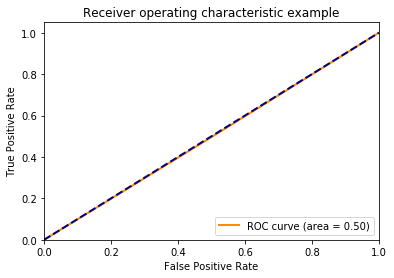

In [32]:
plot_auc_curve(y_decimal_val, decimal_prediction, datatype="decimal")

#### Performance Summary

In [33]:
accuracy_summary(y_decimal_val, decimal_prediction)

Accuracy : 0.5057272727272727
Precision : 0.07579672695951765
Recall : 0.4886949623165411
